In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import DummyVecEnv
from custom_environment_project import CustomStockTradingEnv

In [9]:
def train(stock, start_date, end_date, 
          model_name="PPO", features=["Date", "Close", "MACD", "Signal", "RSI", "CCI", "ADX"], 
          window_size=10, k_value=1000, starting_balance=100000, gamma=0.99, num_timesteps=250):
    '''
    This function will train either A2C or PPO using the custom environment created in custom_environment.py.
    The model will be saved and can be loaded later for evaluation.

    Parameters:
    stock: string of stock ticker
    start_date: string of start of training period in format "YYYY-MM-DD"
    end_date: string of end of training period in format "YYYY-MM-DD"
    model: string of model to use, either "PPO" or "A2C"
    features: list of features to use, default is what you see
    window_size: int of window size to use, default is 10
    k_value: int of max number of shares to buy/sell at a time
    starting_balance: int of starting balance of account    
    '''
    df = pd.read_csv(f'data/{stock}.csv')
    df = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)]
    df = df[features]
    df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")
    df.set_index("Date", inplace=True)

    env = CustomStockTradingEnv(df, window_size=window_size, k=k_value, starting_balance=starting_balance)
    env = DummyVecEnv([lambda: env])
    if model_name == "PPO":
        model = PPO('MlpPolicy', env, gamma=gamma, verbose=0)
    elif model_name == "A2C":
        model = A2C('MlpPolicy', env, gamma=gamma, verbose=0)
    else:
        raise ValueError("Please select PPO or A2C")
    # eval_callback = EvalCallback(env, eval_freq=100, n_eval_episodes=5)
    # model.learn(total_timesteps=num_timesteps, callback=[eval_callback])
    model.learn(total_timesteps=num_timesteps)
    
    # Save trained model (this is not the same way you save a Tensorflow model)
    if not os.path.exists("models"):
        os.mkdir("models")
    model.save(f"models/{stock}_{model_name}")
    print(f"Model saved as {stock}_{model_name}")

    obs = env.reset()
    for i in range(len(df)):
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        if done:
            info = info[0]
            account_balances = info['account_balance']
            num_shares = info['num_shares']
            total_portfolio_value = info['total_portfolio_value']
            break

    print("Account balance: {}".format(account_balances[-1]))
    print("Number of shares: {}".format(num_shares[-1]))
    print("Total portfolio value: {}".format(total_portfolio_value[-1]))

    # Plot training results
    plt.figure(figsize=(15, 6))
    plt.plot(total_portfolio_value, label='Portfolio value')
    plt.title(f"Portfolio Value, {stock} Stock")
    plt.xlabel(f"Day {start_date} - {end_date}")
    plt.ylabel("Portfolio Value ($)")

    # Save plot
    if not os.path.exists("plots"):
        os.mkdir("plots")
    plt.savefig(f"plots/training_{stock}_{model_name}.png")
    plt.show()


def evaluate(stock, start_date, end_date, trained_model, 
             features=["Date", "Close", "MACD", "Signal", "RSI", "CCI", "ADX"], 
             window_size=10, k_value=1000, starting_balance=100000):
    '''
    Load the saved model from the path "trained_model" and evaluate it on the testing data.
    The testing data should be a period of time after the training data that the model has not seen.
    '''
    df = pd.read_csv(f'data/{stock}.csv')
    if end_date is not None:
        df = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)]
    else:
        df = df[(df["Date"] >= "2023-01-01")]
        end_date = "Present"
    df = df[features]
    df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")
    df.set_index("Date", inplace=True)

    # Create the environment used to test the agent
    env = CustomStockTradingEnv(df, window_size=window_size, k=k_value, starting_balance=starting_balance)
    env = DummyVecEnv([lambda: env])
    if trained_model.endswith("PPO"):
        model = PPO.load(trained_model)
    elif trained_model.endswith("A2C"):
        model = A2C.load(trained_model)
    else:
        raise ValueError("Please select PPO or A2C")
    
    # Remember to set random seed for reproducibility
    model.set_random_seed(0)

    obs = env.reset()
    for i in range(len(df)):
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        if done:
            info = info[0]
            account_balances = info['account_balance']
            num_shares = info['num_shares']
            total_portfolio_value = info['total_portfolio_value']
            break

    # Length is len(df) - window_size = 46
    # print(len(df), len(total_portfolio_value))

    print("Model: {}".format(trained_model))
    print("Account balance: {}".format(account_balances[-1]))
    print("Number of shares: {}".format(num_shares[-1]))
    print("Total portfolio value: {}".format(total_portfolio_value[-1]))

    # Plot testing results
    plt.figure(figsize=(15, 6))
    plt.plot(total_portfolio_value, label='Portfolio value')
    plt.title(f"Portfolio Value, {stock} Stock")
    plt.xlabel(f"Day {start_date} - {end_date}")
    plt.ylabel("Portfolio Value ($)")
    plt.savefig(f"plots/testing_{stock}_{trained_model.split('_')[-1]}.png")
    plt.show()


def evaluate_both(stock, start_date, end_date, trained_model1, trained_model2,
             features=["Date", "Close", "MACD", "Signal", "RSI", "CCI", "ADX"], 
             window_size=10, k_value=1000, starting_balance=100000):
    '''
    Load the saved model from the path "trained_model" and evaluate it on the testing data.
    The testing data should be a period of time after the training data that the model has not seen.
    '''
    df = pd.read_csv(f'data/{stock}.csv')
    if end_date is not None:
        df = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)]
    else:
        df = df[(df["Date"] >= "2023-01-01")]
        end_date = "Present"
    df = df[features]
    df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")
    df.set_index("Date", inplace=True)

    # We test the first trained model (A2C)
    env = CustomStockTradingEnv(df, window_size=window_size, k=k_value, starting_balance=starting_balance)
    env = DummyVecEnv([lambda: env])
    if trained_model1.endswith("PPO"):
        model1 = PPO.load(trained_model1)
    elif trained_model1.endswith("A2C"):
        model1 = A2C.load(trained_model1)
    else:
        raise ValueError("Please select PPO or A2C")
    
    model1.set_random_seed(0)
    obs = env.reset()
    for i in range(len(df)):
        action, _ = model1.predict(obs)
        obs, reward, done, info = env.step(action)
        if done:
            info = info[0]
            account_balances1 = info['account_balance']
            num_shares1 = info['num_shares']
            total_portfolio_value1 = info['total_portfolio_value']
            break

    # Then we test the second trained model (PPO)
    env = CustomStockTradingEnv(df, window_size=window_size, k=k_value, starting_balance=starting_balance)
    env = DummyVecEnv([lambda: env])
    if trained_model2.endswith("PPO"):
        model2 = PPO.load(trained_model2)
    elif trained_model2.endswith("A2C"):
        model2 = A2C.load(trained_model2)
    else:
        raise ValueError("Please select PPO or A2C")
    
    model2.set_random_seed(0)
    obs = env.reset()
    for i in range(len(df)):
        action, _ = model2.predict(obs)
        obs, reward, done, info = env.step(action)
        if done:
            info = info[0]
            account_balances2 = info['account_balance']
            num_shares2 = info['num_shares']
            total_portfolio_value2 = info['total_portfolio_value']
            break

    # Plot testing results
    plt.figure(figsize=(7, 6))
    plt.plot(total_portfolio_value1, label='Portfolio Value (A2C)')
    plt.plot(total_portfolio_value2, label='Portfolio Value (PPO)')
    plt.title(f"Portfolio Value, {stock} Stock")
    plt.xlabel(f"Day {start_date} - {end_date}")
    plt.ylabel("Portfolio Value ($)")
    plt.legend(loc="best")
    plt.savefig(f"plots/testing_{stock}_ensemble.png")
    plt.show()

A2C Training


c:\Users\DELSTEI9\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Model saved as AAPL_A2C
Account balance: 99294.52453117949
Number of shares: 23128
Total portfolio value: 3096914.6186473905


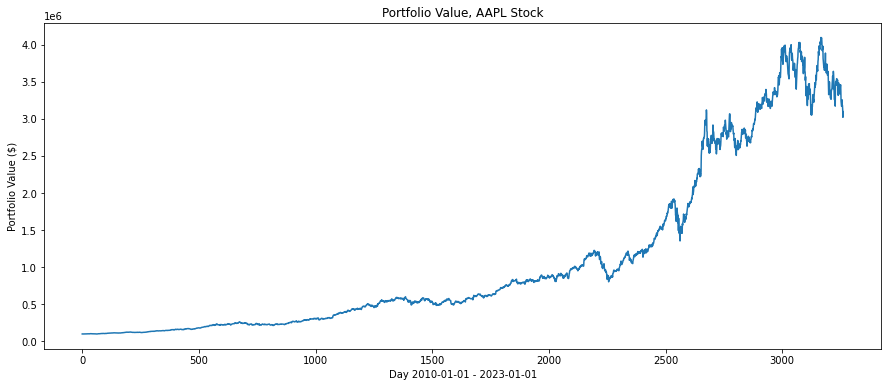

PPO Training


c:\Users\DELSTEI9\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Model saved as AAPL_PPO
Account balance: 99230.45683790001
Number of shares: 24155
Total portfolio value: 3229960.021580942


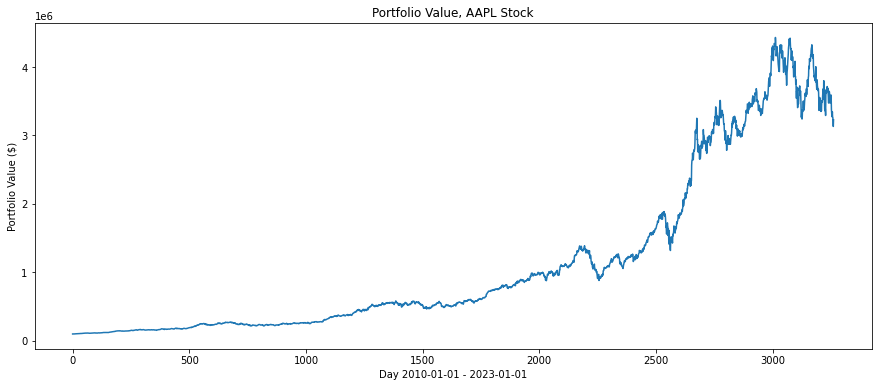

In [10]:
# Training 
stock = "AAPL"
start_train = "2010-01-01"
end_train = "2023-01-01"
model = "A2C"
features = ["Date", "Close", "MACD", "Signal", "RSI", "CCI", "ADX"]
window_size = 10
k_value = 100
starting_balance = 100000
gamma = 0.95
num_timesteps = 250

# A2C model training
print('A2C Training')
train(stock, start_train, end_train, model, features, window_size, k_value, starting_balance, gamma, num_timesteps)

# PP0 model training
print('PPO Training')
model = "PPO"
train(stock, start_train, end_train, model, features, window_size, k_value, starting_balance, gamma, num_timesteps)

Evaluate A2C
Model: models/AAPL_A2C
Account balance: 99928.35108741766
Number of shares: 421
Total portfolio value: 181236.08314308172


c:\Users\DELSTEI9\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


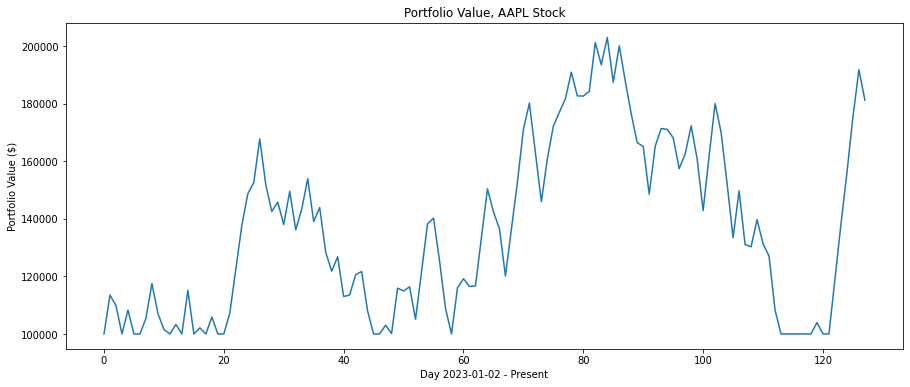

Evaluate PPO


c:\Users\DELSTEI9\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Model: models/AAPL_PPO
Account balance: 99929.51787731935
Number of shares: 393
Total portfolio value: 175829.60979626467


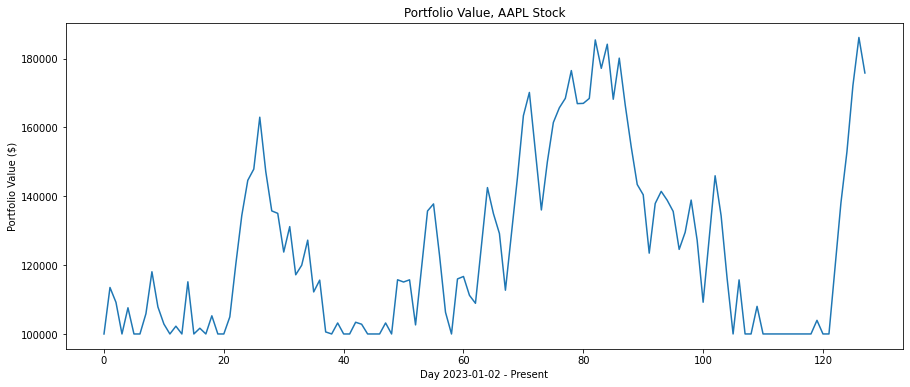

Evaluate Ensemble A2C and PPO


c:\Users\DELSTEI9\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


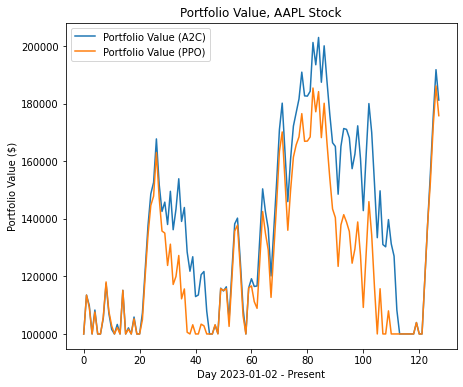

In [12]:
# Evaluation
start_test = "2023-01-02"
end_test = None
trained_model = f"models/{stock}_A2C"
print('Evaluate A2C')
evaluate(stock, start_test, end_test, trained_model, features, window_size, k_value, starting_balance)
trained_model = f"models/{stock}_PPO"
print('Evaluate PPO')
evaluate(stock, start_test, end_test, trained_model, features, window_size, k_value, starting_balance)

trained_model1 = f"models/{stock}_A2C"
trained_model2 = f"models/{stock}_PPO"
print('Evaluate Ensemble A2C and PPO')
evaluate_both(stock, start_test, end_test, trained_model1, trained_model2, features, window_size, k_value, starting_balance)

Different Reward Function: A2C Eval


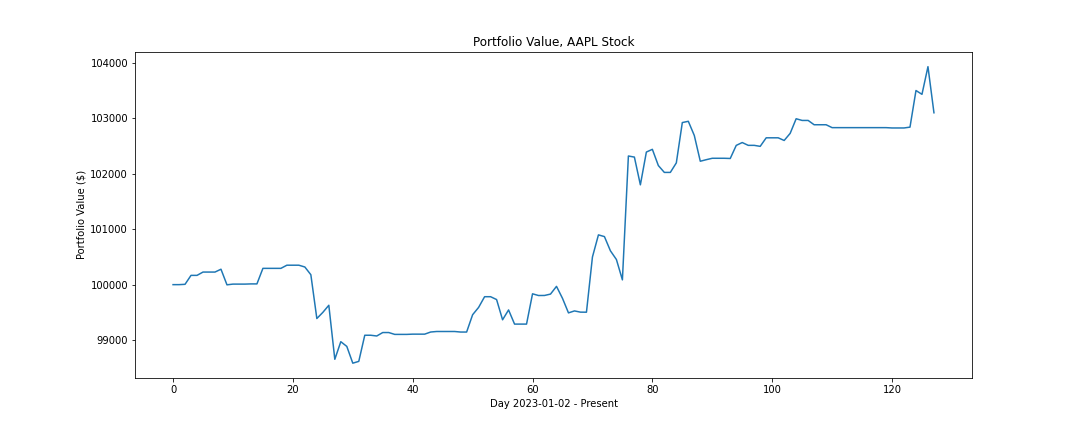

Different Reward Function: PPO Eval


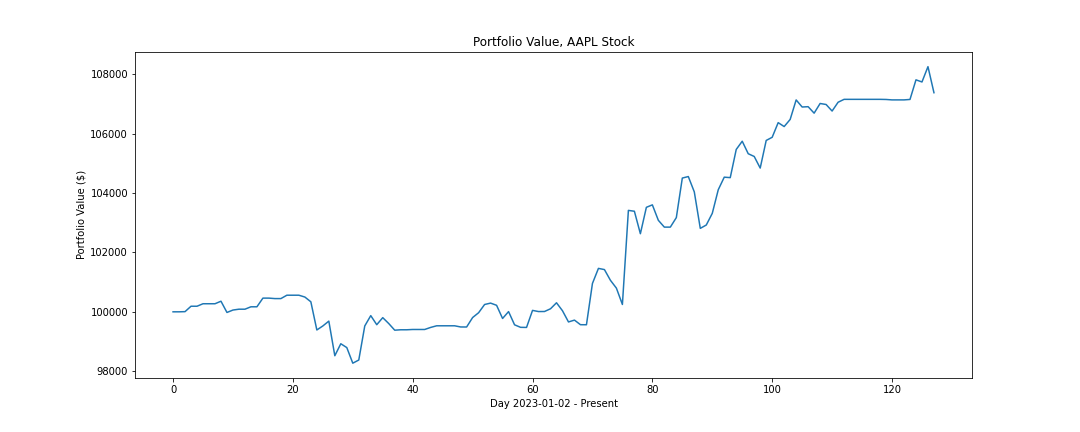

Different Reward Function: Ensemble Output of A2C and PPO


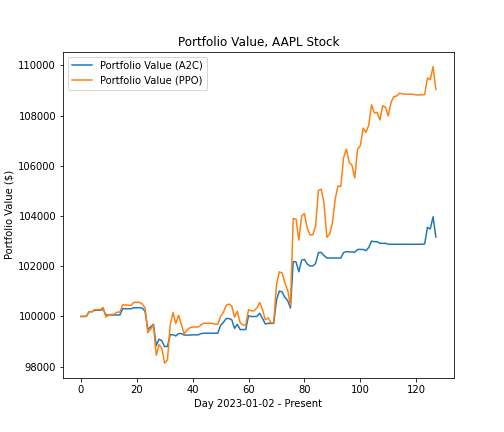

In [17]:
# Results with a different Reward function 
# The code can be found in the folderstructure: 'Eval and Tests'

from IPython.display import Image, display

# Read image
# Output Images
print('Different Reward Function: A2C Eval')
display(Image(filename='Eval and Tests/plots/testing_AAPL_A2C.png'))
print('Different Reward Function: PPO Eval')
display(Image(filename='Eval and Tests/plots/testing_AAPL_PPO.png'))
print('Different Reward Function: Ensemble Output of A2C and PPO')
display(Image(filename='Eval and Tests/plots/testing_AAPL_ensemble.png'))


